# Анализ продаж чая и кофе в США

Cтруктура нашего проекта:

1. Постановка задачи
2. Сбор данных и анализ их качества
3. Предварительная обработка
4. Визуализация
5. Создание новых признаков
6. Гипотезы
7.  Машинное обучение

## Постановка задачи

1. Проанализировать данные и составить графики, которые можно было бы продемонстрировать на дашборде
2. Оценить корреляционные связи между известными признаками
3. Построить модель, предсказывающую маржинальность продажи кофе и чая по ряду факторов

## Сбор данных и анализ их качества

Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import numba
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import requests
import bs4
import time
import json
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder,
    StandardScaler, MinMaxScaler, RobustScaler, Normalizer)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import IPython

In [ ]:
# Настраиваем параметры:
np.random.seed(2022)
sns.set_style('whitegrid')
# Персональные данные
api_token = {"username":"quvirymile","key":"e5b392afbc1801af55fcd47fc5b5a36d"} # TODO: change
# Warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загружаем данные с kaggle
%%capture pip_log
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dsfelix/us-stores-sales
!unzip -u us-stores-sales.zip

In [ ]:
# Считываем файл csv в DataFrame
sales_data = pd.read_csv('sales.csv')
sales_data

,Area Code,State,Market,Market Size,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Date,Product Type,Product,Type
0,203,Connecticut,East,Small Market,107.0,176.0,292.0,116.0,69.0,38.0,962.0,110.0,110.0,160.0,270.0,2,04/01/10 00:00:00,Coffee,Columbian,Regular
1,203,Connecticut,East,Small Market,75.0,135.0,225.0,90.0,60.0,29.0,1148.0,90.0,80.0,130.0,210.0,2,07/01/10 00:00:00,Coffee,Columbian,Regular
2,203,Connecticut,East,Small Market,122.0,195.0,325.0,130.0,73.0,42.0,1134.0,130.0,110.0,180.0,290.0,2,11/01/10 00:00:00,Coffee,Columbian,Regular
3,203,Connecticut,East,Small Market,105.0,174.0,289.0,115.0,69.0,37.0,1166.0,110.0,100.0,160.0,260.0,2,12/01/10 00:00:00,Coffee,Columbian,Regular
4,203,Connecticut,East,Small Market,104.0,135.0,223.0,90.0,56.0,29.0,1148.0,90.0,80.0,130.0,210.0,2,07/01/11 00:00:00,Coffee,Columbian,Regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,985,Louisiana,South,Small Market,-6.0,66.0,113.0,47.0,72.0,42.0,-395.0,0.0,40.0,50.0,90.0,4,07/01/10 00:00:00,Espresso,Caffe Latte,Regular
4244,985,Louisiana,South,Small Market,-7.0,61.0,105.0,44.0,68.0,39.0,-508.0,10.0,30.0,60.0,90.0,4,08/01/10 00:00:00,Espresso,Caffe Latte,Regular
4245,985,Louisiana,South,Small Market,-3.0,76.0,131.0,55.0,79.0,49.0,-1053.0,0.0,40.0,60.0,100.0,4,12/01/10 00:00:00,Espresso,Caffe Latte,Regular
4246,985,Louisiana,South,Small Market,1.0,87.0,160.0,63.0,86.0,57.0,37.0,0.0,50.0,70.0,120.0,4,04/01/11 00:00:00,Espresso,Caffe Latte,Regular


## Предварительныя обработка

Cодержимое колонок датасета из источника:


* Area Code: Код магазина(внутренняя нумерация);
* State: Штат, в котором находится магазин;
* Market: Регион, в котором находится магазин;
* Market Size: Размер магазина;
* Profit: Выручка в долларах (\$);
* Margin: Profit + Total Expenses (\$) ИЛИ Sales - COGS (\$);
* Sales: Values Acquired in Sales (\$);
* COGS: Себестоимость реализованной продукции(Cost of Goods Sold) (\$);
* Total Expenses: Total Expenses to get the Product to Sell (\$);
* Marketing: Затраты на маркетинг (\$);
* Inventory: Inventory Value of the Product in the Sale Moment (\$);
* Budget Profit: Expected Profit (\$);
* Budget COGS: Expected COGS (\$);
* Budget Margin: Expected Profit + Expected Total Expenses (\$) ИЛИ Expected Sales * - Expected COGS (\$);
* Budget Sales: Expected Value Acquired in Sales ($);
* ProductID: ID товара;
* Date: Дата продажи;
* Product Type: Категория товара;
* Product: Описание товара;
* Type: Тип товара;

Изучим, в каком виде они представлены в таблице

In [ ]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4248 entries, 0 to 4247
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area Code       4248 non-null   int64  
 1   State           4248 non-null   object 
 2   Market          4248 non-null   object 
 3   Market Size     4248 non-null   object 
 4   Profit          4248 non-null   float64
 5   Margin          4248 non-null   float64
 6   Sales           4248 non-null   float64
 7   COGS            4248 non-null   float64
 8   Total Expenses  4248 non-null   float64
 9   Marketing       4248 non-null   float64
 10  Inventory       4248 non-null   float64
 11  Budget Profit   4248 non-null   float64
 12  Budget COGS     4248 non-null   float64
 13  Budget Margin   4248 non-null   float64
 14  Budget Sales    4248 non-null   float64
 15  ProductId       4248 non-null   int64  
 16  Date            4248 non-null   object 
 17  Product Type    4248 non-null   o

Два категориальных признака хранятся в формате целых чисел (int64), остальные 6 - в строковом формате; дата также записана в строке и все денежные значения предствалены в формате чисел с плавающей запятой (float64).

Можем заметить, что несмотря на то, что в датасете все денежные значения указаны в формате float64, они фактически целые. Проверим на всякий случай это на всем датасете, если это окажется так, то переведём все такие значения в целочисленный формат.

In [ ]:
# Преобразуем в целые числа, если это возможно:
def convert_to_int64(dataset, name: str):
    if all((value % 1) == 0 for value in dataset[name]):
        dataset[name] = dataset[name].convert_dtypes(convert_integer=True)

for column_name in sales_data.select_dtypes(['float64']).head():
    convert_to_int64(sales_data, column_name)

sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4248 entries, 0 to 4247
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Area Code       4248 non-null   int64 
 1   State           4248 non-null   object
 2   Market          4248 non-null   object
 3   Market Size     4248 non-null   object
 4   Profit          4248 non-null   Int64 
 5   Margin          4248 non-null   Int64 
 6   Sales           4248 non-null   Int64 
 7   COGS            4248 non-null   Int64 
 8   Total Expenses  4248 non-null   Int64 
 9   Marketing       4248 non-null   Int64 
 10  Inventory       4248 non-null   Int64 
 11  Budget Profit   4248 non-null   Int64 
 12  Budget COGS     4248 non-null   Int64 
 13  Budget Margin   4248 non-null   Int64 
 14  Budget Sales    4248 non-null   Int64 
 15  ProductId       4248 non-null   int64 
 16  Date            4248 non-null   object
 17  Product Type    4248 non-null   object
 18  Product 

Мы преобразовали все цены в целые числа, так они будут удобнее отображаться в датасете. (В дальнейшем, как оказалось, нам пришлось переводить опять в формат float, так как некоторые функции работают только с форматом float)

Теперь изучим категориальные признаки, представленные строками:

In [ ]:
categories = ['State', 'Market', 'Market Size', 'Product Type', 'Product', 'Type']
for category in categories:
    print(f'{category}:', sales_data[category].unique(), '\n')

State: ['Connecticut' 'Washington' 'California' 'Texas' 'New York' 'Ohio'
 'Illinois' 'Louisiana' 'Florida' 'Wisconsin' 'Colorado' 'Missouri' 'Iowa'
 'Massachusetts' 'Oklahoma' 'Utah' 'Oregon' 'New Mexico' 'New Hampshire'
 'Nevada'] 

Market: ['East' 'West' 'South' 'Central'] 

Market Size: ['Small Market' 'Major Market'] 

Product Type: ['Coffee' 'Tea' 'Espresso' 'Herbal Tea'] 

Product: ['Columbian' 'Green Tea' 'Caffe Mocha' 'Decaf Espresso' 'Lemon' 'Mint'
 'Darjeeling' 'Decaf Irish Cream' 'Chamomile' 'Earl Grey' 'Caffe Latte'
 'Amaretto' 'Regular Espresso'] 

Type: ['Regular' 'Decaf'] 



Как видим, для колонок, в которых есть большое число различных уникальных значений (State и Product), в датасете есть числовые представления (столбцы Area Code и ProductId соответственно), а остальные имеют малое число уникальных значений.

Теперь исследуем столбец с датами:

In [ ]:
pd.to_datetime(sales_data['Date']).unique()

array(['2010-04-01T00:00:00.000000000', '2010-07-01T00:00:00.000000000',
       '2010-11-01T00:00:00.000000000', '2010-12-01T00:00:00.000000000',
       '2011-07-01T00:00:00.000000000', '2011-08-01T00:00:00.000000000',
       '2011-09-01T00:00:00.000000000', '2011-10-01T00:00:00.000000000',
       '2011-11-01T00:00:00.000000000', '2010-06-01T00:00:00.000000000',
       '2010-10-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2011-02-01T00:00:00.000000000', '2011-03-01T00:00:00.000000000',
       '2011-04-01T00:00:00.000000000', '2011-05-01T00:00:00.000000000',
       '2011-12-01T00:00:00.000000000', '2010-02-01T00:00:00.000000000',
       '2010-05-01T00:00:00.000000000', '2010-08-01T00:00:00.000000000',
       '2010-03-01T00:00:00.000000000', '2010-09-01T00:00:00.000000000',
       '2011-06-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

Данные даются для каждого значения за первое число месяца => данные приведены за месяц, а значит день, час и т.д. не несут информации. Для удобства переведем даты в формат date

In [ ]:
sales_data['Date'] = pd.to_datetime(sales_data['Date']).dt.to_period('m')

Посмотрим полученные данные:

In [ ]:
sales_data.head()

,Area Code,State,Market,Market Size,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Date,Product Type,Product,Type
0,203,Connecticut,East,Small Market,107,176,292,116,69,38,962,110,110,160,270,2,2010-04,Coffee,Columbian,Regular
1,203,Connecticut,East,Small Market,75,135,225,90,60,29,1148,90,80,130,210,2,2010-07,Coffee,Columbian,Regular
2,203,Connecticut,East,Small Market,122,195,325,130,73,42,1134,130,110,180,290,2,2010-11,Coffee,Columbian,Regular
3,203,Connecticut,East,Small Market,105,174,289,115,69,37,1166,110,100,160,260,2,2010-12,Coffee,Columbian,Regular
4,203,Connecticut,East,Small Market,104,135,223,90,56,29,1148,90,80,130,210,2,2011-07,Coffee,Columbian,Regular


Мы преобразовали и проанализировали часть данных, теперь они удобнее отображаются в датасете и в нужных для нас форматах. Переходим к части визуализации:

## Визуализация

In [ ]:
sales_data.drop(columns=['ProductId', 'Area Code']).describe(percentiles=[.1, .25, .5, 0.75, 0.9, 0.99])

,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales
count,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0
mean,61.097693,104.293315,192.987524,84.433145,54.063559,31.185028,749.381356,60.913371,74.830508,100.819209,175.649718
std,101.708546,94.342522,151.133127,67.249769,32.352598,27.023264,661.031896,79.546123,66.238145,92.602725,148.891522
min,-638.0,-302.0,17.0,0.0,10.0,0.0,-3534.0,-320.0,0.0,-210.0,0.0
10%,-4.0,34.0,63.0,28.0,19.0,8.0,312.0,10.0,20.0,30.0,50.0
25%,17.0,52.75,100.0,43.0,33.0,13.0,432.0,20.0,30.0,50.0,80.0
50%,40.0,76.0,138.0,60.0,46.0,22.0,619.0,40.0,50.0,70.0,130.0
75%,92.0,132.0,230.0,100.0,65.0,39.0,910.5,80.0,90.0,130.0,210.0
90%,171.0,222.0,387.0,200.0,102.0,74.0,1310.0,140.0,170.0,200.0,360.0
99%,389.06,428.0,693.0,294.0,152.0,120.0,3076.0,360.0,320.0,470.0,740.0


Итак, мы можем понять, что:
1. В датасете хранятся отрицательные значения в столбце Inventory, что невозможно (невозможно хранить отрицательное число единиц товара). Поэтому заменим все отрицательные значения нулями.
2. Для большинства столбцов видим, что среднеквадратическое отклонение превосходит 50-й перцентиль, что может означать выбросы (это также подтверждает информация о соотношении 90-го, 99-го и 100-го перцентиля)

In [ ]:
sales_data['Inventory'] = sales_data['Inventory'].apply(lambda x: x if x >= 0 else 0)
sales_data[['Inventory']].describe()

,Inventory
count,4248.000000
mean,769.115348
std,610.080105
min,0.000000
25%,432.000000
50%,619.000000
75%,910.500000
max,8252.000000


Теперь изучим статистику по категориальным значениям

In [ ]:
descr = sales_data.describe(include=['object'])
descr.loc['loc'] = (descr.loc['freq'] / descr.loc['count']) * descr.loc['unique']
descr
#loc - локализованность (насколько много самой часто встречающейся категории)

,State,Market,Market Size,Product Type,Product,Type
count,4248,4248,4248,4248,4248,4248
unique,20,4,2,4,13,2
top,Utah,West,Small Market,Espresso,Columbian,Regular
freq,288,1344,2544,1176,480,2400
loc,1.355932,1.265537,1.19774,1.107345,1.468927,1.129944


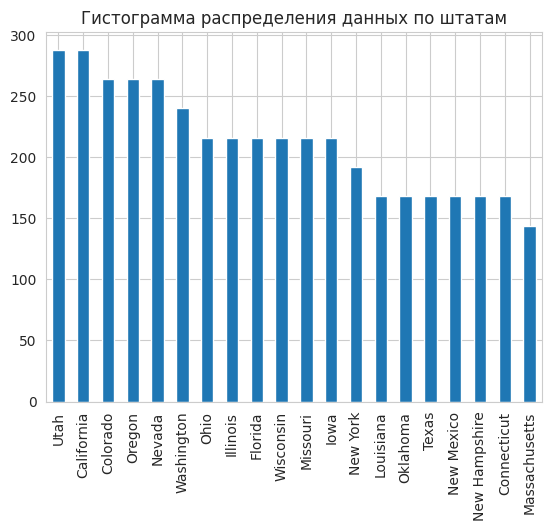

In [ ]:
sales_data['State'].value_counts().plot(kind='bar')
plt.title('Гистограмма распределения данных по штатам')
plt.show()

Можем заметить, что для штатов Utah, California, Colorado в нашем датасете больше данных, чем для других штатов
Также видим, что для каждого товара, продаваемого в неком магазине, собрана полная статистика за два года.

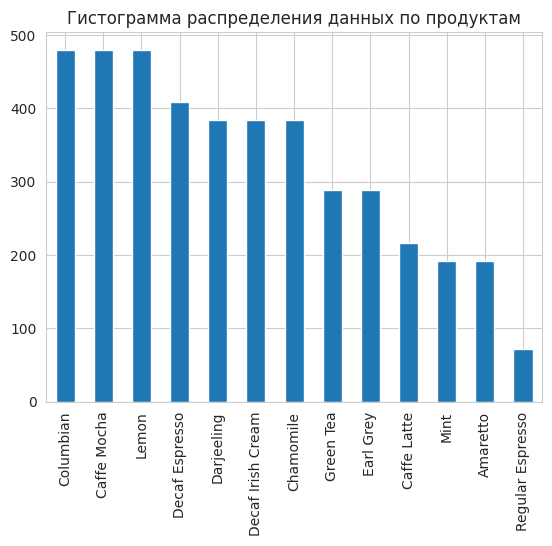

In [ ]:
sales_data['Product'].value_counts().plot(kind='bar')
plt.title('Гистограмма распределения данных по продуктам')
plt.show()

Выше можем видеть статистику по различным продуктам. Можем тут заметить, что в наиболее популярных категориях данных ~ в 5 раз больше, чем в наименее популярных.

Теперь изучим кореляции между значеними и построим корреляционную матрицу:

In [ ]:
sales_data['Month'] = sales_data['Date'].apply(lambda x : x.month)
sales_data.corr(numeric_only=True)

,Area Code,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Month
Area Code,1.000000,0.013979,0.029278,0.055220,0.080471,0.044552,0.051232,0.082893,0.011994,0.063720,0.022871,0.042572,2.429694e-02,1.348084e-02
Profit,0.013979,1.000000,0.920604,0.797331,0.464838,0.199976,0.225465,-0.035389,0.937606,0.479862,0.876844,0.758830,-5.869339e-02,8.030853e-03
Margin,0.029278,0.920604,1.000000,0.938809,0.678797,0.521254,0.531947,0.123208,0.922812,0.680549,0.963460,0.901981,-7.959521e-02,1.276869e-02
Sales,0.055220,0.797331,0.938809,1.000000,0.886651,0.689350,0.710515,0.386915,0.815435,0.862882,0.920757,0.956538,-4.807745e-02,1.071546e-02
COGS,0.080471,0.464838,0.678797,0.886651,1.000000,0.782534,0.818271,0.667762,0.514967,0.947762,0.688587,0.849901,2.142304e-03,1.463609e-02
Total Expenses,0.044552,0.199976,0.521254,0.689350,0.782534,1.000000,0.966167,0.471480,0.255811,0.744259,0.530776,0.661217,-7.336890e-02,6.231384e-03
Marketing,0.051232,0.225465,0.531947,0.710515,0.818271,0.966167,1.000000,0.534155,0.279315,0.773709,0.543039,0.681946,-4.222699e-02,1.377227e-02
Inventory,0.082893,-0.035389,0.123208,0.386915,0.667762,0.471480,0.534155,1.000000,0.037206,0.619266,0.177629,0.385972,4.001659e-02,1.321218e-01
Budget Profit,0.011994,0.937606,0.922812,0.815435,0.514967,0.255811,0.279315,0.037206,1.000000,0.579176,0.949637,0.848285,-1.477584e-01,7.596332e-03
Budget COGS,0.063720,0.479862,0.680549,0.862882,0.947762,0.744259,0.773709,0.619266,0.579176,1.000000,0.750422,0.911598,-1.566830e-01,8.278223e-03


Теперь визуализируем нашу корреляционную матрицу, чтобы нагляднее видеть самые высокие линейные взаимосвязи. (Переменные ProductId и Area Code убрали, так как они не несут смысловой знаимости для корреляции)

[Text(0.5, 1.0, 'Heatmap of financial parameters relation')]

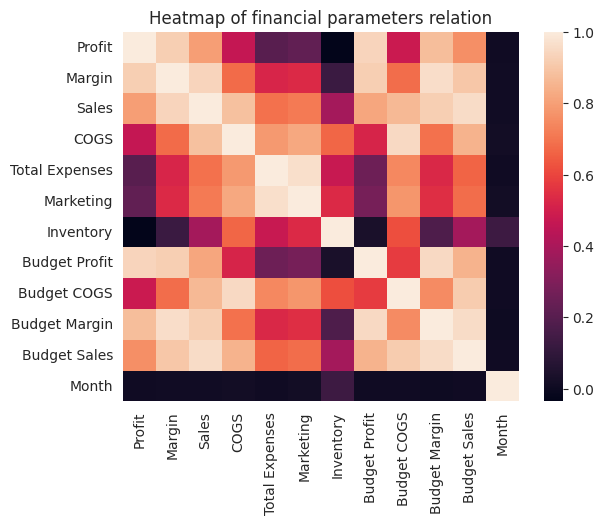

In [ ]:
corr = sales_data.drop(columns=['ProductId', 'Area Code']).corr(numeric_only=True)
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns).set(title='Heatmap of financial parameters relation')

Корреляция между тратами на маркетинг и запасами составила 0.534155, визуализируем эту слабую положительную взаимосвязь с помощью диаграммы рассеяния с дополнительной линией регрессии, которая будет наглядно  показывать тенденцию в данных.

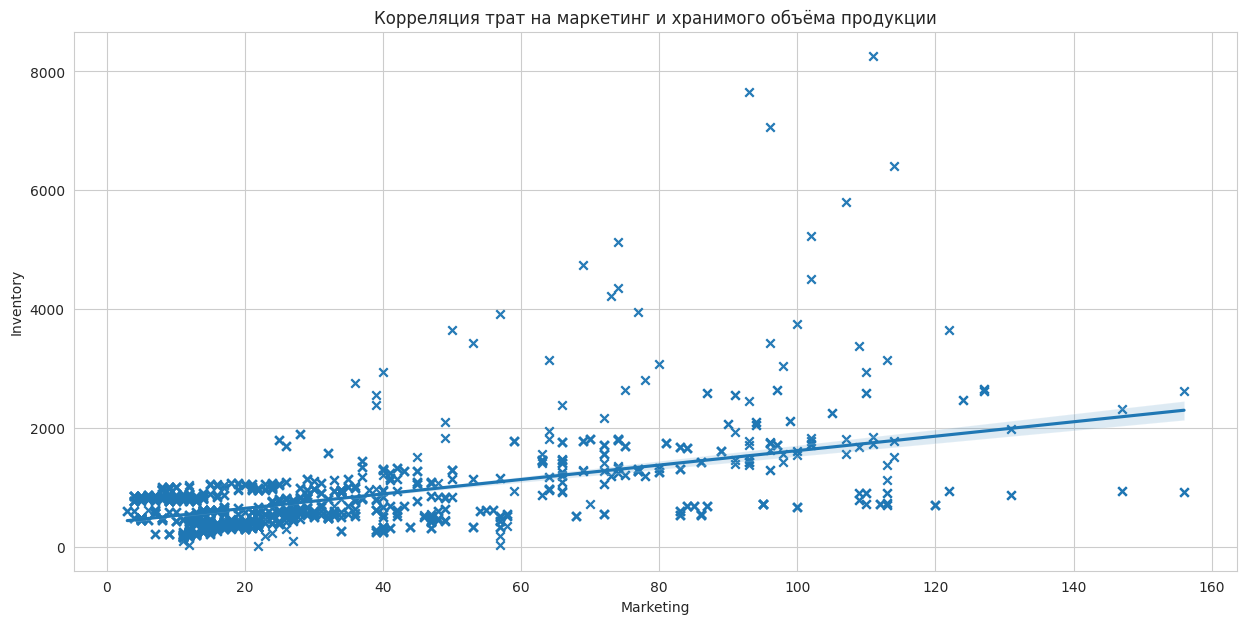

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Корреляция трат на маркетинг и хранимого объёма продукции')

plt.xlabel('Маркетинг (USD$)')
plt.ylabel('Объём(ед.)')

sns.regplot(
    x=sales_data['Marketing'].astype('float64').apply(lambda x : x if x > 0 else None),
    y=sales_data['Inventory'].astype('float64').apply(lambda x : x if x > 0 else None),
    marker='x')

plt.show()

Данных очень много, для более наглядного представления приблизим зону с большой плотностью данных:

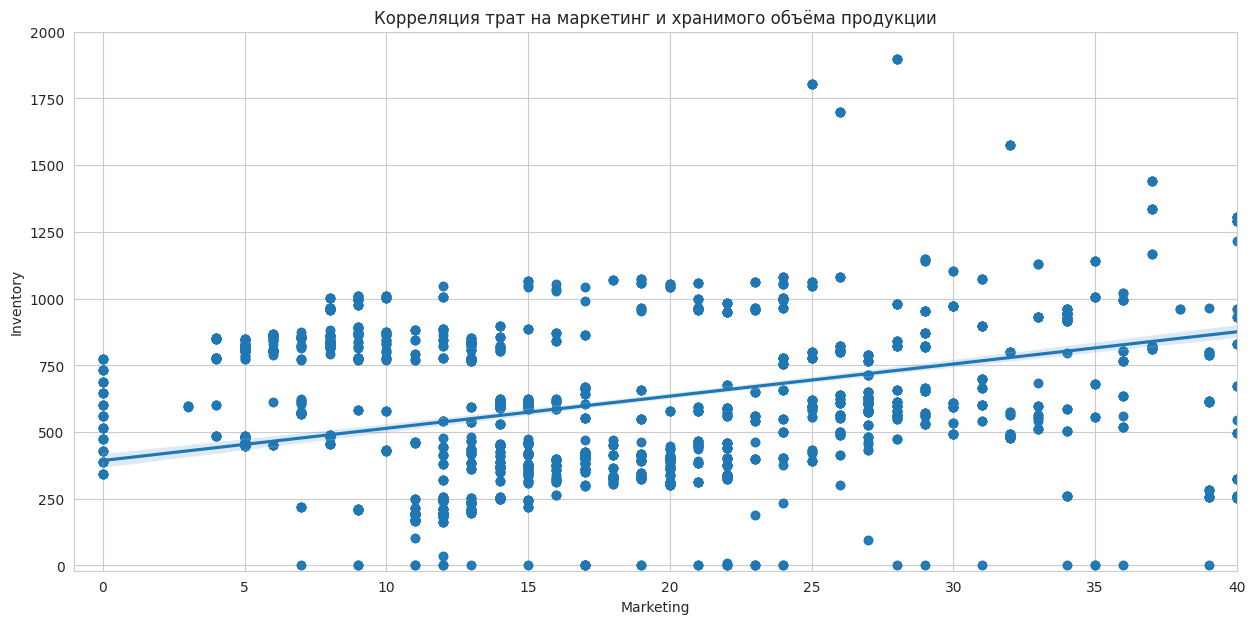

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Корреляция трат на маркетинг и хранимого объёма продукции')

plt.xlabel('Маркетинг (USD$)')
plt.ylabel('Объём(ед.)')

graphobj = sns.regplot(
    x=sales_data['Marketing'].astype('float64'),
    y=sales_data['Inventory'].astype('float64'))

graphobj.set(xlim=(-1, 40), ylim=(-20, 2000))

plt.show()

А теперь построим такую же диаграмму для Total Expenses и Marketing, у них очень сильная линейная взаимосвязь:  0.966167

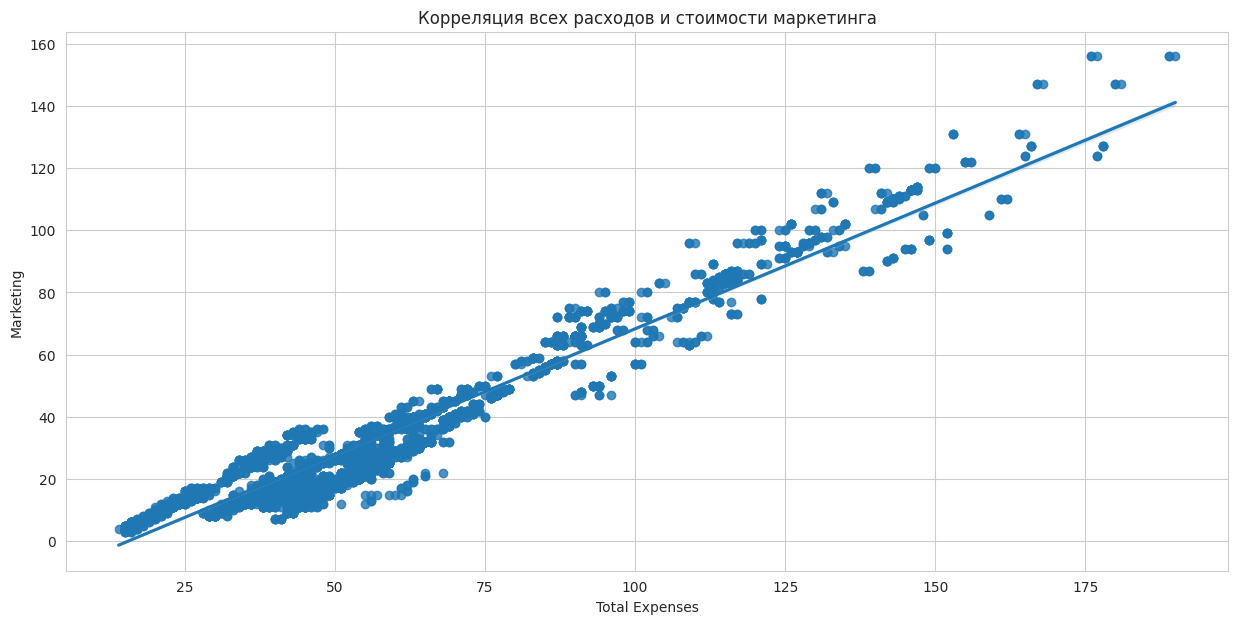

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Корреляция всех расходов и стоимости маркетинга')

plt.xlabel('Расход (U$)')
plt.ylabel('Маркетинг (U$)')

sns.regplot(
    x=sales_data['Total Expenses'].astype('float64').apply(lambda x : x if x > 0 else None),
    y=sales_data['Marketing'].astype('float64').apply(lambda x : x if x > 0 else None))

plt.show()

Теперь построим средние данные трат на маркетинг (переменная Marketing) за каждый месяц за 2 года:

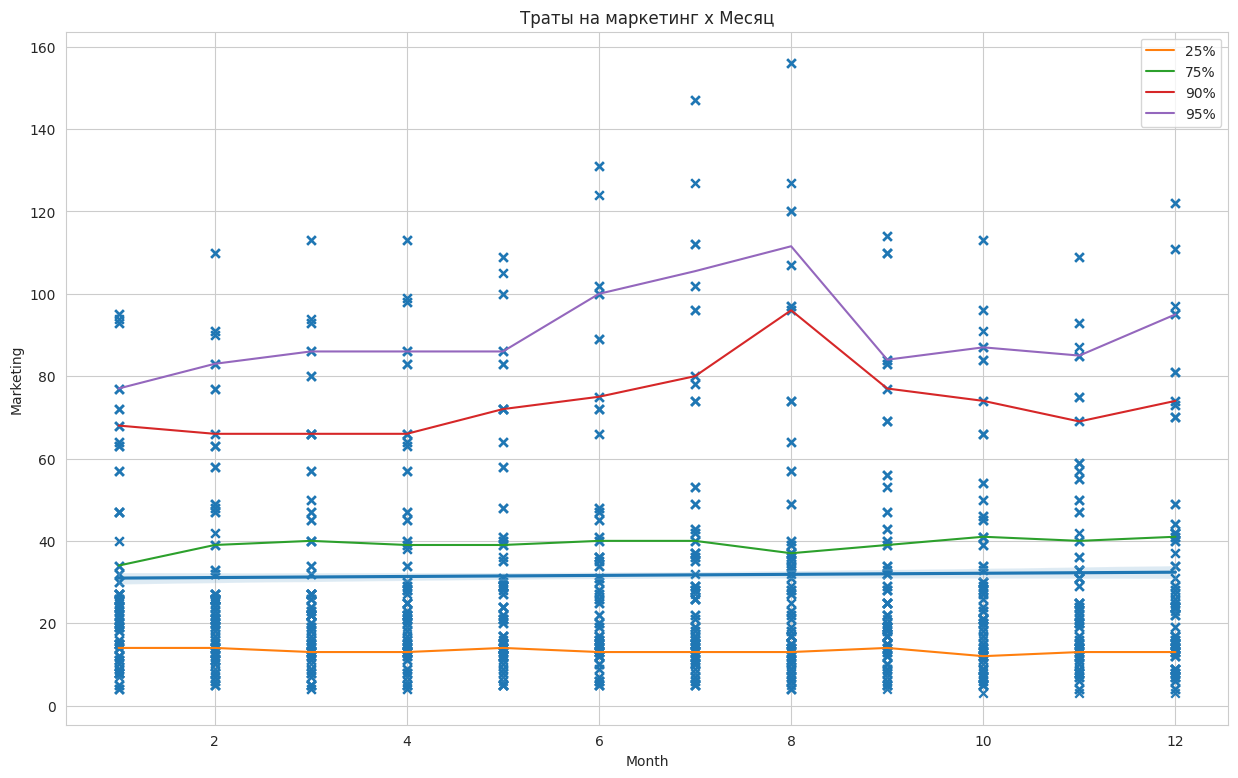

In [ ]:
plt.figure(figsize=(15, 9))

plt.title('Траты на маркетинг x Месяц')

plt.xlabel('Месяц')
plt.ylabel('Траты на Маркетинг (U$)')

sns.regplot(
    y=sales_data['Marketing'].astype('float64').apply(lambda x : x if x > 0 else None),
    x=sales_data['Month'].astype('float64').apply(lambda x : x if x > 0 else None),
    marker='x')

sales_data.groupby('Month').quantile(q=0.25, numeric_only=True)['Marketing'].plot(label='25%', legend=True);
sales_data.groupby('Month').quantile(q=0.75, numeric_only=True)['Marketing'].plot(label='75%', legend=True);
sales_data.groupby('Month').quantile(q=0.9, numeric_only=True)['Marketing'].plot(label='90%', legend=True);
sales_data.groupby('Month').quantile(q=0.95, numeric_only=True)['Marketing'].plot(label='95%', legend=True);

Можем заметить по графику, что данные достаточно плотно распределены в области первой квантили (25%). Однако за q = 75% у нас резко падает плотность. Также на диаграмме можем увидеть увеличение больших значений в определённые месяца для 90 и 95-й перцентилей(90-95%)

Плюсом построим диграммы по всем переменным из нашего датасета, чтобы посмотреть распределения:

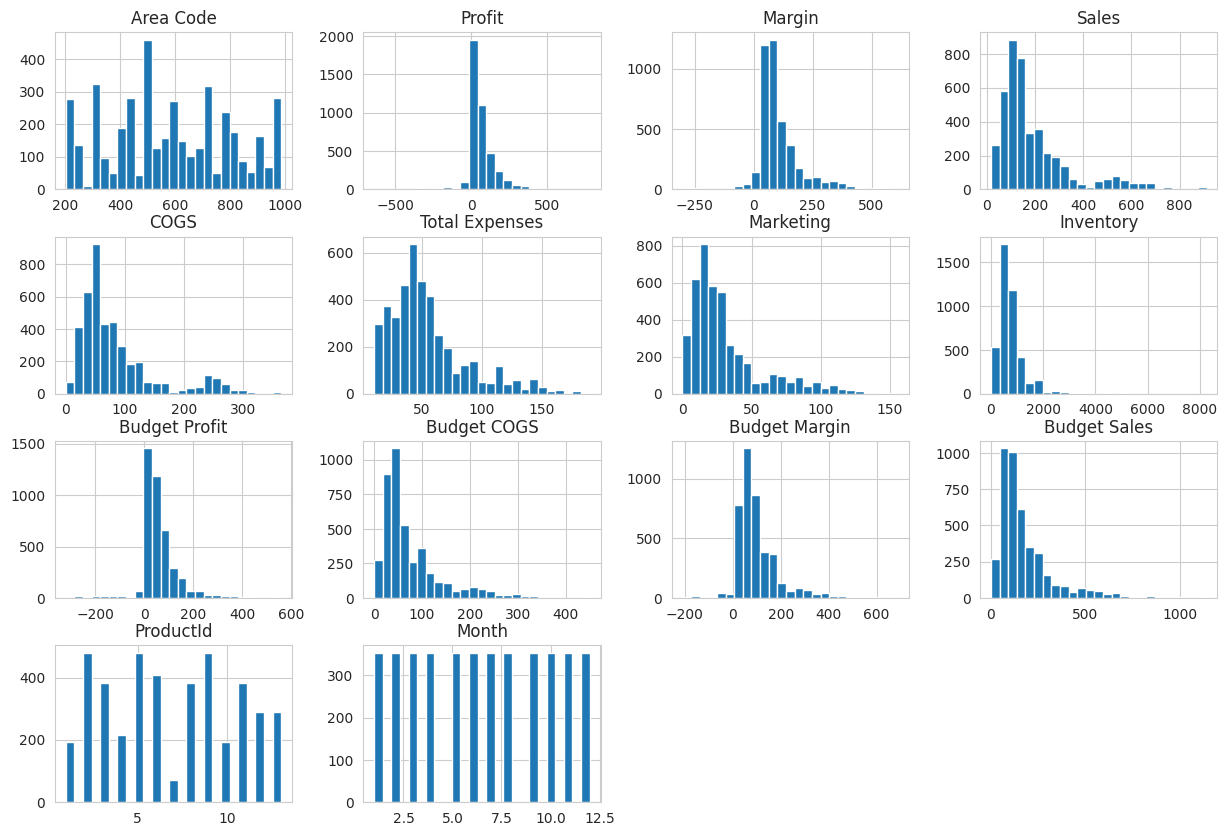

In [ ]:
sales_data.hist(bins=25, figsize=(15, 10));

Уберем переменные, по которым построение гистограммы не будет нести смысла: Area Code, ProductId, Month:

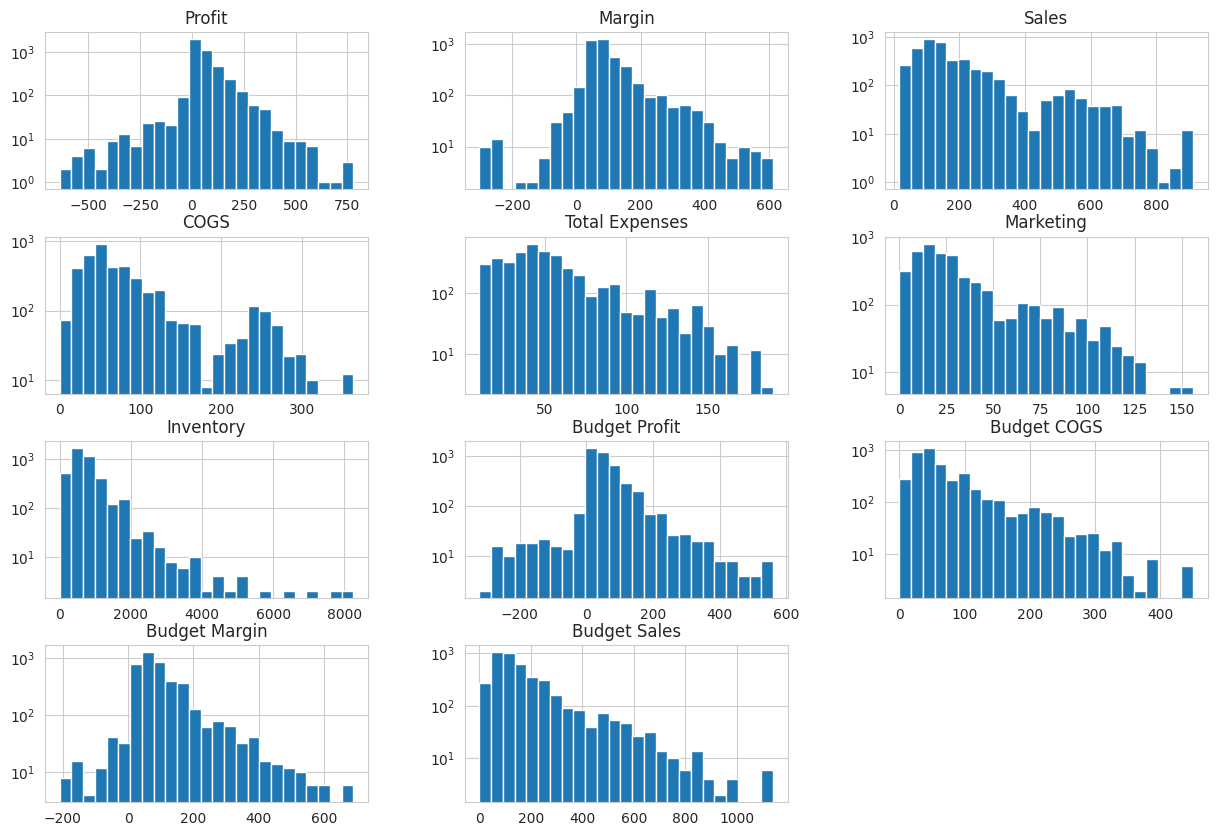

In [ ]:
sales_data.drop(columns=['Area Code', 'ProductId', 'Month']).hist(bins=25, figsize=(15, 10), log=True);

Можем заметить, что данные по переменным Profit, Margin, Budget Profit, Budget Margin распределены приближенно нормально. По всем остальным переменным можем наблюдать смещение влево или ассиметрию

Также рассмотрим распределение продуктов 'Coffee' 'Tea' 'Espresso' 'Herbal Tea' по месяцам

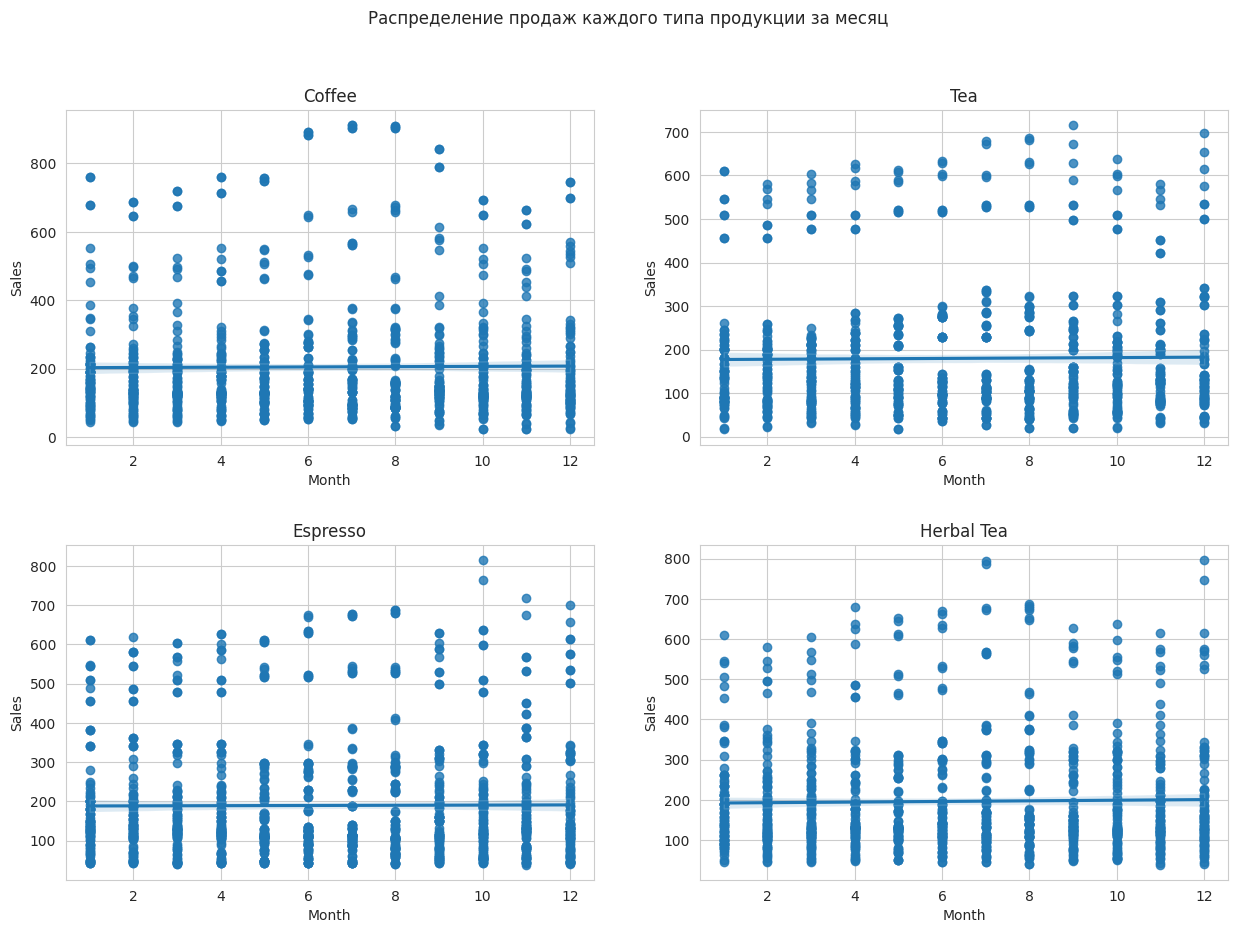

In [ ]:
def type_x_month_sale_distribution(category_name):
    plt.title(category_name)
    plt.ylabel('Продажи ($)')
    plt.xlabel('Месяц')
    sub_data = sales_data.loc[sales_data['Product Type'] == category_name]
    sub_data['Datem'] = sub_data['Date'].copy().apply(lambda x : x.month)
    sns.regplot(y=sub_data['Sales'].astype(float), x=sub_data['Month'])

fig = plt.figure(figsize=(15,10))
fig.suptitle("Распределение продаж каждого типа продукции за месяц")

product_types = ['Coffee', 'Tea', 'Espresso', 'Herbal Tea']
for i in range(4):
    plt.subplot(2, 2, i+1)
    type_x_month_sale_distribution(product_types[i])

plt.subplots_adjust(hspace=0.3)
plt.show()

Кроме того, построим диаграмму, которая будет показывать средние продажи за месяц по всем штатам

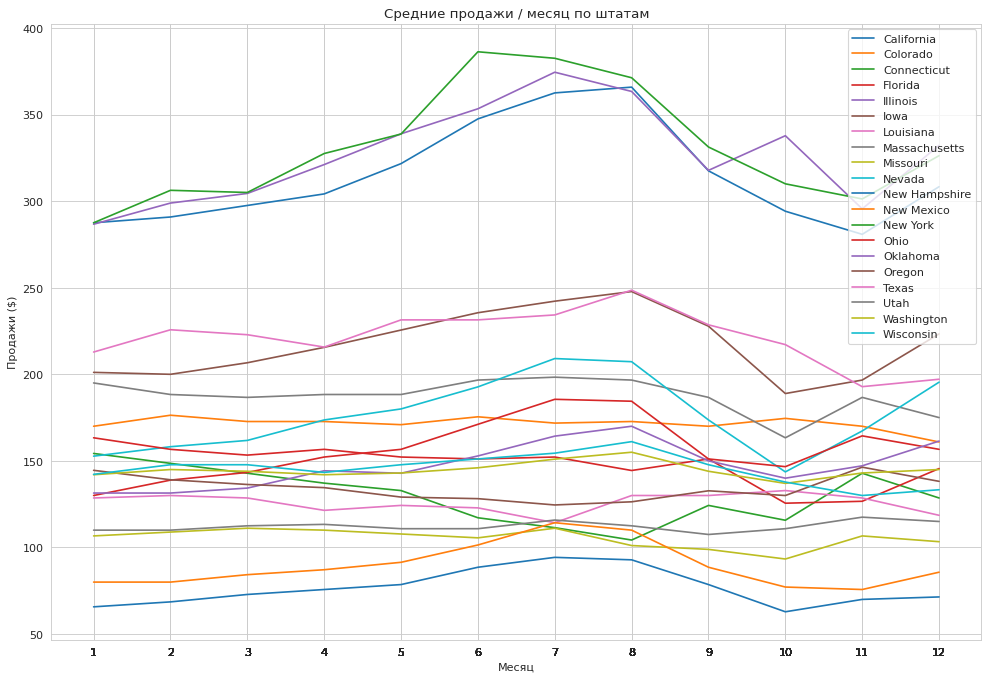

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=80)

sales_trend_data = sales_data.groupby(['State', 'Month']).mean(numeric_only=True)
sales_trend_data = sales_trend_data.reset_index()
sales_trend_data.set_index(['Month', 'State'], inplace=True)
sales_trend_data['Budget Sales'].groupby('State').plot(
    legend=True)
sales_trend_data = sales_trend_data.reset_index()
sales_trend_data.set_index('Month', inplace=True)
ax.set_xticks(sales_trend_data.index-1)
sales_trend_data = sales_trend_data.reset_index()
ax.set_xticklabels(sales_trend_data['Month'])
plt.title('Средние продажи / месяц по штатам')
plt.ylabel('Продажи ($)')
plt.xlabel('Месяц')
plt.show()

Упростим визуализацию графика выше, так как большое кол-во линий делает график громоздким:

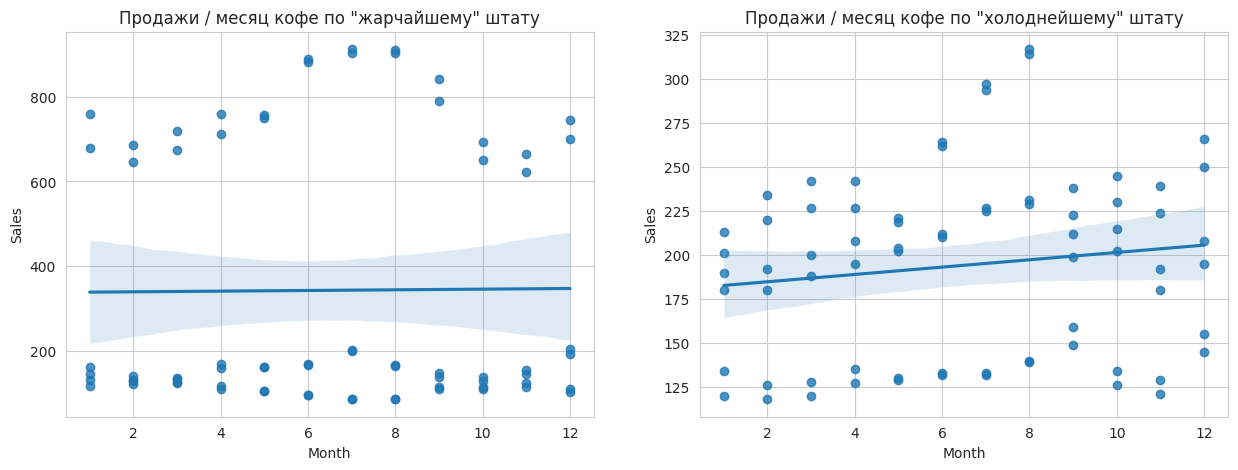

In [ ]:
#Заранее посмотрели самый жаркий и "холодный" штат
pd.options.mode.chained_assignment = None
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('')
# One of the hottest
plt.title('Продажи / месяц кофе по "жарчайшему" штату')
plt.ylabel('Sales ($)')
sub_data = sales_data.loc[sales_data['Product Type'] == 'Coffee'].loc[sales_data['State'] == 'California']
sns.regplot(y=sub_data['Sales'].astype(float), x=sub_data['Month'])

plt.subplot(1, 2, 2)
# one of the coldest
plt.title('Продажи / месяц кофе по "холоднейшему" штату')
plt.ylabel('Sales ($)')
sub_data = sales_data.loc[sales_data['Product Type'] == 'Coffee'].loc[sales_data['State'] == 'Wisconsin']
sns.regplot(y=sub_data['Sales'].astype(float), x=sub_data['Month'])

plt.show()

На жарком штате (Калифорния) видим сезонные колебания, тут корреляции нет, однако в штате Висконсин корреляция есть (может быть инфляция и тд), сезонные колебания тоже есть, но выражены слабее как видим по графику

Также рассмотрим, как на выручку влияет год:

In [ ]:
sales_data['Date'].value_counts()

2010-04    177
2010-07    177
2011-06    177
2010-09    177
2010-03    177
2010-08    177
2010-05    177
2010-02    177
2011-12    177
2011-05    177
2011-04    177
2011-03    177
2011-02    177
2011-01    177
2010-10    177
2010-06    177
2011-11    177
2011-10    177
2011-09    177
2011-08    177
2011-07    177
2010-12    177
2010-11    177
2010-01    177
Freq: M, Name: Date, dtype: int64

Как видим данные по годам и месяцам распределены равномерно

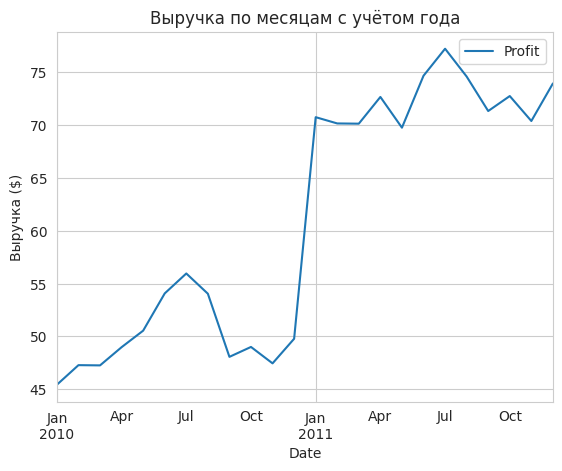

In [ ]:
sales_data.pivot_table(index='Date', values='Profit', aggfunc='mean').plot()
plt.title('Выручка по месяцам с учётом года')
plt.ylabel('Выручка ($)')
plt.show()

Заметим, что средняя выручка выросла почти в два раза, при этом резким скачком, что значит, что год можно использовать как один из факторов влияющий на выручку!

## Создание новых признаков


Создадим признак численность населения + площадь штата

In [ ]:
response = requests.get('https://worldpopulationreview.com/states')
soup = bs4.BeautifulSoup(response.text, 'html.parser')
population_data = pd.DataFrame(
    json.loads(
        soup.find(
            'script', id='__NEXT_DATA__'
            ).text
        )['props']['pageProps']['data']
    )
population_data.head()

,fips,state,densityMi,pop2023,pop2022,pop2020,pop2019,pop2010,growthRate,growth,growthSince2010,area,rank
0,6,California,249.81347,38915693,39029342,39501653,39276883.3,37253956,-0.00291,-113649,0.04461,155779,1
1,48,Texas,116.75553,30500280,30029572,29232474,28823782.7,25145561,0.01567,470708,0.21295,261232,2
2,12,Florida,422.59351,22661577,22244823,21589602,21310772.8,18801310,0.01873,416754,0.20532,53625,3
3,36,New York,413.71663,19496810,19677151,20108296,20035276.6,19378102,-0.00916,-180341,0.00613,47126,4
4,42,Pennsylvania,289.02749,12931957,12972008,12994440,12965233.9,12702379,-0.00309,-40051,0.01807,44743,5


Отсюда нас интересует популяция на момент 2010 года и площадь штата.

## Гипотезы


1. Летом возрастает стоимость крупных закупок.
 * [Общая по штатам](#scrollTo=6BMwjRlosXhC)
2. Штат влияет на продажи, в т.ч. на дифференциацию аннуальных продаж
 * [MI-анализ показывает, что есть связь между отдельным aread-state и выручкой](#scrollTo=Gg2k9kJIAoSp)
 * [Корреляция между числом жителей штата и профитом 0.27, продажами - 0.34 ](#scrollTo=_ML)

## Машинное обучение

Будем использовать линейную регрессию и качество модели оценим по RMSE

In [ ]:
X = sales_data.copy()

In [ ]:
X['Population'] = 0
for state, row in population_data.iterrows():
    X.loc[X['State'] == row.state, ['Population']] = row.pop2010

In [ ]:
X

,Area Code,State,Market,Market Size,Profit,Margin,Sales,COGS,Total Expenses,Marketing,...,Budget COGS,Budget Margin,Budget Sales,ProductId,Date,Product Type,Product,Type,Month,Population
0,203,Connecticut,East,Small Market,107,176,292,116,69,38,...,110,160,270,2,2010-04,Coffee,Columbian,Regular,4,3574097
1,203,Connecticut,East,Small Market,75,135,225,90,60,29,...,80,130,210,2,2010-07,Coffee,Columbian,Regular,7,3574097
2,203,Connecticut,East,Small Market,122,195,325,130,73,42,...,110,180,290,2,2010-11,Coffee,Columbian,Regular,11,3574097
3,203,Connecticut,East,Small Market,105,174,289,115,69,37,...,100,160,260,2,2010-12,Coffee,Columbian,Regular,12,3574097
4,203,Connecticut,East,Small Market,104,135,223,90,56,29,...,80,130,210,2,2011-07,Coffee,Columbian,Regular,7,3574097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,985,Louisiana,South,Small Market,-6,66,113,47,72,42,...,40,50,90,4,2010-07,Espresso,Caffe Latte,Regular,7,4533372
4244,985,Louisiana,South,Small Market,-7,61,105,44,68,39,...,30,60,90,4,2010-08,Espresso,Caffe Latte,Regular,8,4533372
4245,985,Louisiana,South,Small Market,-3,76,131,55,79,49,...,40,60,100,4,2010-12,Espresso,Caffe Latte,Regular,12,4533372
4246,985,Louisiana,South,Small Market,1,87,160,63,86,57,...,50,70,120,4,2011-04,Espresso,Caffe Latte,Regular,4,4533372


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4248 entries, 0 to 4247
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   Area Code       4248 non-null   int64    
 1   State           4248 non-null   object   
 2   Market          4248 non-null   object   
 3   Market Size     4248 non-null   object   
 4   Profit          4248 non-null   Int64    
 5   Margin          4248 non-null   Int64    
 6   Sales           4248 non-null   Int64    
 7   COGS            4248 non-null   Int64    
 8   Total Expenses  4248 non-null   Int64    
 9   Marketing       4248 non-null   Int64    
 10  Inventory       4248 non-null   int64    
 11  Budget Profit   4248 non-null   Int64    
 12  Budget COGS     4248 non-null   Int64    
 13  Budget Margin   4248 non-null   Int64    
 14  Budget Sales    4248 non-null   Int64    
 15  ProductId       4248 non-null   int64    
 16  Date            4248 non-null   period[M]


In [ ]:
# Год в биномиальной форме
X['year_f'] = X['Date'].apply(lambda x : x.year) - 2010
# Месяца в порядке 1-12 внутри выборки
X['Month_o'] = X['Month'] + X['year_f']*12

###### Корреляции в наборе для ML

Нам надо избавиться от сильно скореллированных величин среди используемых для обучения, отметим такие данные как *corr*

In [ ]:
data_corr = X[[
    'Profit', 'Margin', 'Sales', 'COGS', 'Total Expenses', 'Marketing',
    'Inventory', 'Budget Profit', 'Budget COGS', 'Budget Margin',
    'Budget Sales', 'Population']].corr(numeric_only=True).abs()
data_corr[data_corr > 0.5] = 'corr'
data_corr

,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,Population
Profit,corr,corr,corr,0.464838,0.199976,0.225465,0.035389,corr,0.479862,corr,corr,0.209946
Margin,corr,corr,corr,corr,corr,corr,0.123208,corr,corr,corr,corr,0.274345
Sales,corr,corr,corr,corr,corr,corr,0.386915,corr,corr,corr,corr,0.345911
COGS,0.464838,corr,corr,corr,corr,corr,corr,corr,corr,corr,corr,0.378548
Total Expenses,0.199976,corr,corr,corr,corr,corr,0.47148,0.255811,corr,corr,corr,0.25502
Marketing,0.225465,corr,corr,corr,corr,corr,corr,0.279315,corr,corr,corr,0.3018
Inventory,0.035389,0.123208,0.386915,corr,0.47148,corr,corr,0.037206,corr,0.177629,0.385972,0.241812
Budget Profit,corr,corr,corr,corr,0.255811,0.279315,0.037206,corr,corr,corr,corr,0.223357
Budget COGS,0.479862,corr,corr,corr,corr,corr,corr,corr,corr,corr,corr,0.406925
Budget Margin,corr,corr,corr,corr,corr,corr,0.177629,corr,corr,corr,corr,0.277169


In [ ]:
#В цифорках
X.corr(numeric_only=True)

,Area Code,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Month,Population,year_f,Month_o
Area Code,1.000000,0.013979,2.927834e-02,0.055220,8.047071e-02,0.044552,5.123189e-02,8.289277e-02,1.199399e-02,6.371986e-02,2.287113e-02,4.257203e-02,2.429694e-02,1.348084e-02,4.741237e-02,-1.135428e-02,-3.118827e-03
Profit,0.013979,1.000000,9.206041e-01,0.797331,4.648382e-01,0.199976,2.254650e-01,-3.538926e-02,9.376062e-01,4.798618e-01,8.768442e-01,7.588298e-01,-5.869339e-02,8.030853e-03,2.099461e-01,1.108570e-01,1.000934e-01
Margin,0.029278,0.920604,1.000000e+00,0.938809,6.787967e-01,0.521254,5.319466e-01,1.232082e-01,9.228119e-01,6.805488e-01,9.634598e-01,9.019808e-01,-7.959521e-02,1.276869e-02,2.743449e-01,-1.170910e-16,6.367666e-03
Sales,0.055220,0.797331,9.388095e-01,1.000000,8.866512e-01,0.689350,7.105149e-01,3.869154e-01,8.154348e-01,8.628820e-01,9.207573e-01,9.565376e-01,-4.807745e-02,1.071546e-02,3.459105e-01,2.725030e-02,2.896370e-02
COGS,0.080471,0.464838,6.787967e-01,0.886651,1.000000e+00,0.782534,8.182707e-01,6.677617e-01,5.149673e-01,9.477621e-01,6.885869e-01,8.499008e-01,2.142304e-03,1.463609e-02,3.785483e-01,-2.905668e-16,7.298927e-03
Total Expenses,0.044552,0.199976,5.212543e-01,0.689350,7.825338e-01,1.000000,9.661667e-01,4.714796e-01,2.558112e-01,7.442592e-01,5.307757e-01,6.612171e-01,-7.336890e-02,6.231384e-03,2.550202e-01,-1.697016e-02,-1.160181e-02
Marketing,0.051232,0.225465,5.319466e-01,0.710515,8.182707e-01,0.966167,1.000000e+00,5.341553e-01,2.793152e-01,7.737093e-01,5.430390e-01,6.819459e-01,-4.222699e-02,1.377227e-02,3.018000e-01,-2.014358e-16,6.868145e-03
Inventory,0.082893,-0.035389,1.232082e-01,0.386915,6.677617e-01,0.471480,5.341553e-01,1.000000e+00,3.720579e-02,6.192661e-01,1.776290e-01,3.859721e-01,4.001659e-02,1.321218e-01,2.418124e-01,-3.472928e-16,6.588837e-02
Budget Profit,0.011994,0.937606,9.228119e-01,0.815435,5.149673e-01,0.255811,2.793152e-01,3.720579e-02,1.000000e+00,5.791765e-01,9.496366e-01,8.482855e-01,-1.477584e-01,7.596332e-03,2.233567e-01,-7.795795e-17,3.788245e-03
Budget COGS,0.063720,0.479862,6.805488e-01,0.862882,9.477621e-01,0.744259,7.737093e-01,6.192661e-01,5.791765e-01,1.000000e+00,7.504222e-01,9.115985e-01,-1.566830e-01,8.278223e-03,4.069253e-01,-2.401126e-16,4.128300e-03


Выше мы уже визуализировали таким же способом матрицу корреляций, здесь такой же принцип:

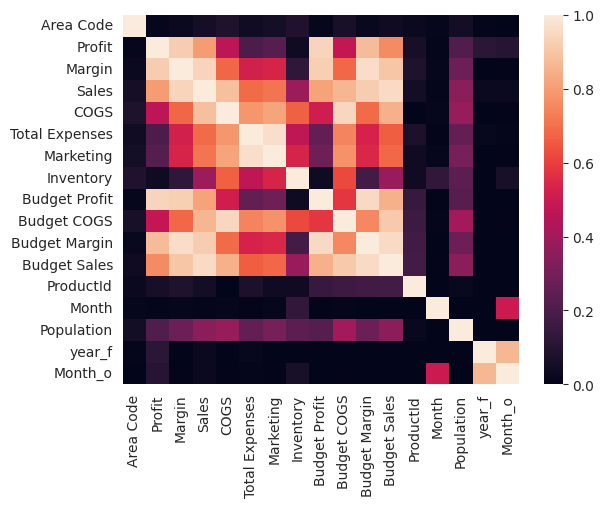

In [ ]:
sns.heatmap(X.corr(numeric_only=True).apply(lambda x : abs(x)))
plt.show()

Удаляем сильно зависимые колонки

In [ ]:
X.drop(['Margin', 'Budget Profit', 'Budget Sales', 'Budget Margin', 'Budget COGS', 'Total Expenses'], axis=1, inplace=True)

Отделим нужное нам значение от датасета:

In [ ]:
y = X.pop('Profit')

Теперь соберём список дискретных, ценовых и непрерывных величин, чтобы позже использовать их:

In [ ]:
X_discrete_features = [col for col in X.columns
                      if X[col].dtype == 'int64']
X_priceval_features = [col for col in X.columns
                      if X[col].dtype == 'Int64']
X_continuous_features = [col for col in X.columns
                        if X[col].dtype =='float64']

discrete_features = X[X_discrete_features].dtypes == int
priceval_features = X[X_priceval_features].dtypes == int
continuous_features = X[X_continuous_features].dtypes == float

Создадим функцию, визуализирующую MI в порядке возрастания:

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information")

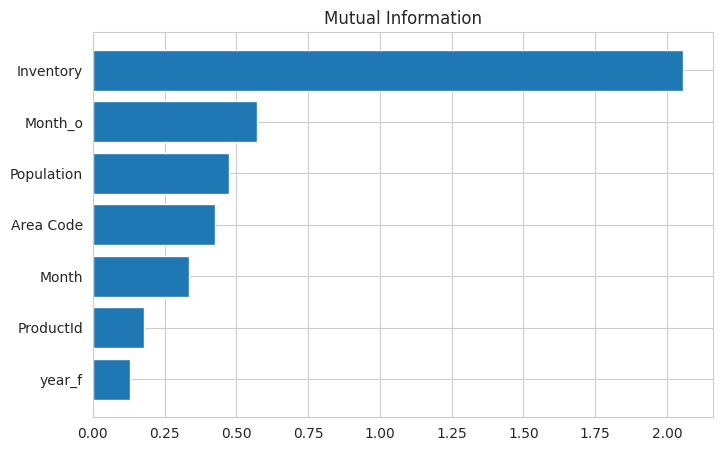

In [ ]:
# Получаем MI по всем выделенным ранее дискретным переменным и предсказываемой переменной
mi_scores_discrete_features = mutual_info_regression(X[X_discrete_features], y, discrete_features=discrete_features, random_state=2004)
# Получаем MI по всем выделенным ранее дискретным переменным и предсказываемой переменной
mi_scores_discrete_features = pd.Series(mi_scores_discrete_features, name='MI Scores 1', index=X_discrete_features)
mi_scores_discrete_features = mi_scores_discrete_features.sort_values(ascending=False)

plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores_discrete_features)

Как можем видеть по графику выше, число закупаемых товаров сильно влияет на итоговую прибыль, а также большой MI-фактор у порядка месяца

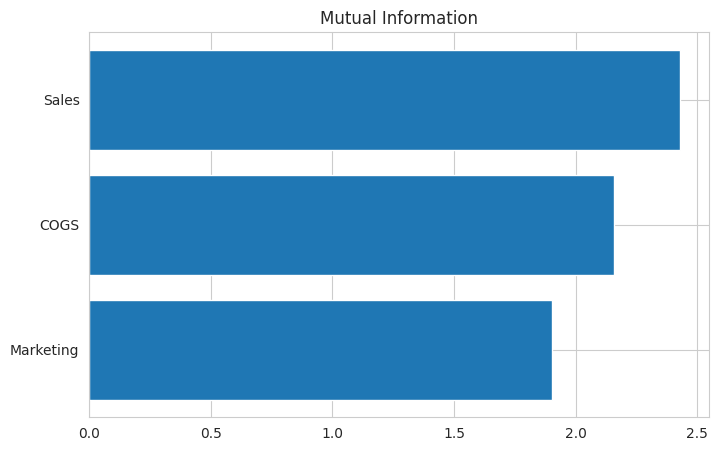

In [ ]:
mi_scores_priceval_features = mutual_info_regression(X[X_priceval_features], y, discrete_features=priceval_features, random_state=2004)
mi_scores_priceval_features = pd.Series(mi_scores_priceval_features, name='MI Scores 2', index=X_priceval_features)
mi_scores_priceval_features = mi_scores_priceval_features.sort_values(ascending=False)

plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores_priceval_features)

Теперь для построения модели берем только числовые данные:

In [ ]:
number_features = [col for col in X.columns
                    if X[col].dtype in ['int64', 'float64', 'Int64']]

Делим выборку на тренировочную и валидационную в соотношении 70/30:

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=2022, train_size=0.70, test_size=0.30)

In [ ]:
# Выбираем все категориальные признаки в тренировочной выборке
cat_ord_features = [col for col in X_train.columns
                  if X_train[col].dtype == 'object']

# Выбираем все категориальные признаки из валидационной выборки, для которых все метки есть в тренировочной, чтобы не было ошибки
good_labels_ord_features = [col for col in cat_ord_features
                          if set(X_valid[col]).issubset(set(X_train[col]))]

# Получаем список признаков, которые не попали в good_labels_ord_features
# Если они есть, то надо поменять выборку(((
bad_labels_ord_features = list(set(cat_ord_features) - set(good_labels_ord_features))

print('Good Labels:', good_labels_ord_features, '\n')
print('Bad Labels:',  bad_labels_ord_features,  '\n')

Good Labels: ['State', 'Market', 'Market Size', 'Product Type', 'Product', 'Type'] 

Bad Labels: [] 



У нас все отлично, выборку менять не нужно, все совпадает

Теперь пределяем функцию, подсчитывающую RMSE (Корень среднеквадратической ошибки), с помощью которой позже оценим нашу модель:

In [ ]:
rmse = lambda predictions, real_values: np.sqrt(mean_squared_error(predictions, real_values))

In [ ]:
# Опеределим, как будут трансформироваться входящие числовые переменные
numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Определим, как будут трансформироваться входящие категориальные переменные
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first')),
])


# определяем препроцессор, указываем какой трансформер использовать для числовых и категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, number_features),
        ('categorical', categorical_transformer, good_labels_ord_features)
        # Let him do it for you https://www.youtube.com/watch?v=mcHb68f8L2Q
    ]
)

Отлично, теперь осталось задать только вид модели (Линейная регрессия) и собрать все воедино

In [ ]:
linear_model = LinearRegression(n_jobs=8)

linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear_model)
])

Обучаем и предсказываем на валидационной выборке:

In [ ]:
linear_pipeline.fit(X_train, y_train)  # Обучение
print('Training Done!')
linear_predictions = linear_pipeline.predict(X_valid)  # Предсказание на валидационной выборке
print('Predictions Done!')

Training Done!
Predictions Done!


Ищем RMSE нашей модели:

In [ ]:
linear_rmse = rmse(linear_predictions, y_valid)
print('Linear Regression RMSE: ', linear_rmse)

Linear Regression RMSE:  20.754392842831614


Нормализуем полученное значение rmse:

$RMSE_{normalised} = \frac{RMSE}{max(y)-min(y)}$

In [ ]:
max_y = y.max()
min_y = y.min()
print(f'max(y) = {max_y}, min(y) = {min_y}')

max(y) = 778, min(y) = -638


In [ ]:
rmse_normalised = linear_rmse/(max_y - min_y)
rmse_normalised

0.014657057092395207

Т.к. RMSE_normalised у качественной модели стремится к нулю, то можно оценить модель как имеющую предсказательную силу!

Теперь оценим точность нашей модели на тренировочной и валидационной выборке:

In [ ]:
print(f'Train Score: {linear_pipeline.score(X_train, y_train) * 100 : .2f}%')
print(f'Validation Score: {linear_pipeline.score(X_valid, y_valid) * 100 : .2f}%')

Train Score:  96.67%
Validation Score:  96.11%


Итак, выведем общие данные о нашей модели:

In [ ]:
model = sm.OLS(y.astype(float), sm.add_constant(X['Sales'].astype(float))).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     7410.
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:39:29   Log-Likelihood:                -23517.
No. Observations:                4248   AIC:                         4.704e+04
Df Residuals:                    4246   BIC:                         4.705e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -42.4560      1.528    -27.788      0.0